In [1]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LightSource, ListedColormap

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import caesarpy as cp

from pyvista import set_plot_theme
set_plot_theme('document')

from pathlib import Path

In [2]:
tstep = 2613600
time = tstep / (24 * 60)
fname = 'mid'
res = '200'
vdrop = '1e-4'
print(time)

1815.0


In [3]:
path_to_file = Path('/work/armitagj/runs/caesar-explore/plastics/tet-microplastic-input/')
filename = path_to_file/f'{fname}{res}_r40_v{vdrop}/results/Grainz{tstep}.asc'

In [4]:
ascfile = path_to_file/f'{fname}{res}_r40_v{vdrop}/results/Elevations{tstep}.asc'
ncols, nrows, geotransform, z = cp.demio.asc2numpy(str(ascfile))
z[z == 9999] = np.nan

ll = (geotransform[0], geotransform[3] + nrows * geotransform[5])
dx = geotransform[1]

_x = np.linspace(ll[0], ll[0] + dx * (ncols -1), ncols)
_y = np.linspace(ll[1] + dx * (nrows -1), ll[1], nrows)
x, y = np.meshgrid(_x, _y, indexing='xy')

ascfile = path_to_file/f'{fname}{res}_r40_v{vdrop}/results/WaterDepths{tstep}.asc'
ncols, nrows, geotransform, water = cp.demio.asc2numpy(str(ascfile))

In [5]:
gmax = 10
imax = nrows
jmax = ncols
smax = 10
index = np.zeros((imax, jmax))
grain = np.zeros((imax, jmax, gmax))
strata = np.ones((imax, jmax, smax, gmax))

active_layer = 1  # active layer thickness

dprops = np.array([0, 0.3244, 0.2335, 0.2206, 0.1375, 0.0508, 0.0187, 0.0047, 0])

for i in range(imax):
    for j in range(jmax):
        for gid, dprop in enumerate(dprops):
            if z[i, j] > 0:
                grain[i, j, gid] = dprop * active_layer
            else:
                grain[i, j, gid] = np.nan

with open(filename) as file:

    #Index coordinates
    x1 = 0
    y1 = 0

    for line in file:
        
        line_vector = line.rstrip().split()

        x1 = int(line_vector[0]) - 1
        y1 = int(line_vector[1]) - 1

        for n in range(gmax):
            grain[x1, y1, n] = float(line_vector[4 + n])

In [6]:
active = np.zeros((imax, jmax))
for i in range(imax):
    for j in range(jmax):
        active[i, j] = np.sum(grain[i, j, :])

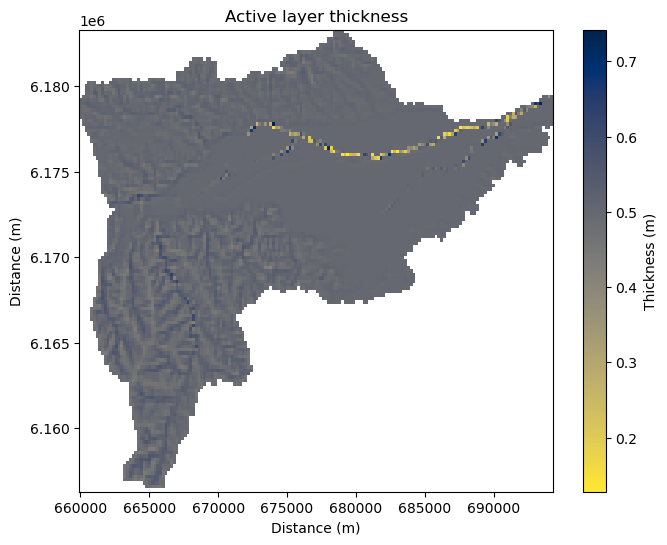

In [7]:
plt.figure(figsize=[6 * ncols / nrows, 6])
plt.pcolormesh(x, y, active, cmap='cividis_r')
plt.colorbar(label='Thickness (m)')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.title('Active layer thickness')
plt.savefig(f'plots/tet-plastic-{fname}-{res}-r40-v{vdrop}-t{int(np.floor(time))}.png', dpi=300)
plt.show()

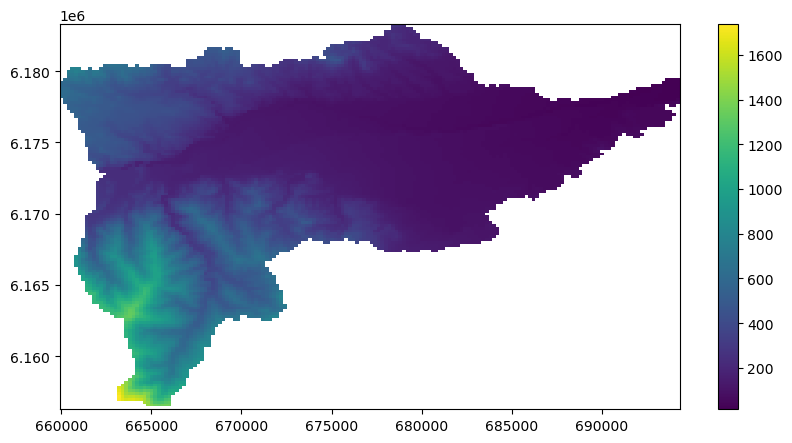

In [8]:
plt.figure(figsize=[10,5])
plt.subplot(111)
plt.pcolormesh(x, y, z)
plt.colorbar()
plt.show()

In [9]:
mi, ma = np.floor(np.nanmin(z)), np.ceil(np.nanmax(z))
levels = np.arange(mi, ma, 200)

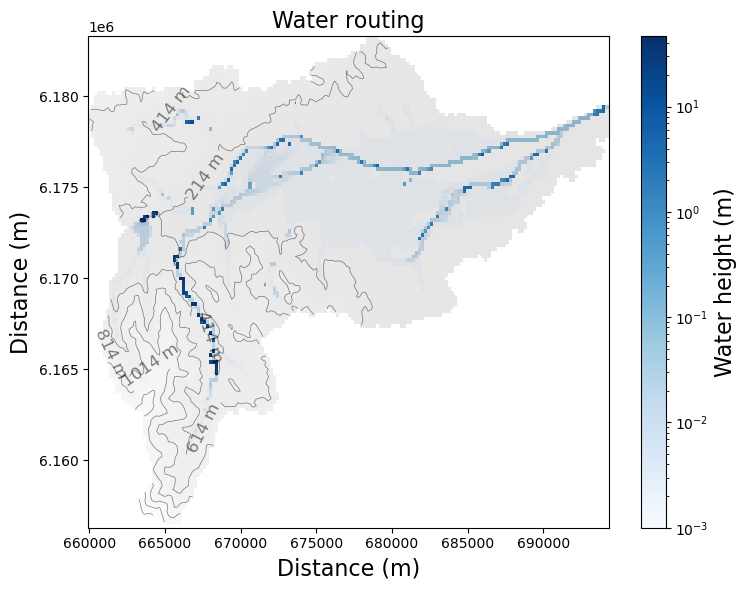

In [10]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} m" if plt.rcParams["text.usetex"] else f"{s} m"

plt.figure(figsize=[6 * ncols / nrows, 6])
plt.pcolormesh(x, y, water, norm=colors.LogNorm(vmin=1e-3, vmax=water.max()), cmap='Blues')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Water height (m)', fontsize=16)
plt.pcolormesh(x, y, z, cmap='gray', alpha=0.1)
cs = plt.contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=12)
plt.xlabel('Distance (m)', fontsize=16)
plt.ylabel('Distance (m)', fontsize=16)
plt.title('Water routing', fontsize=16)
plt.tight_layout()
plt.savefig(f'plots/tet-water-{res}-r40-v{vdrop}-t{int(np.floor(time))}.png', dpi=300)
plt.show()

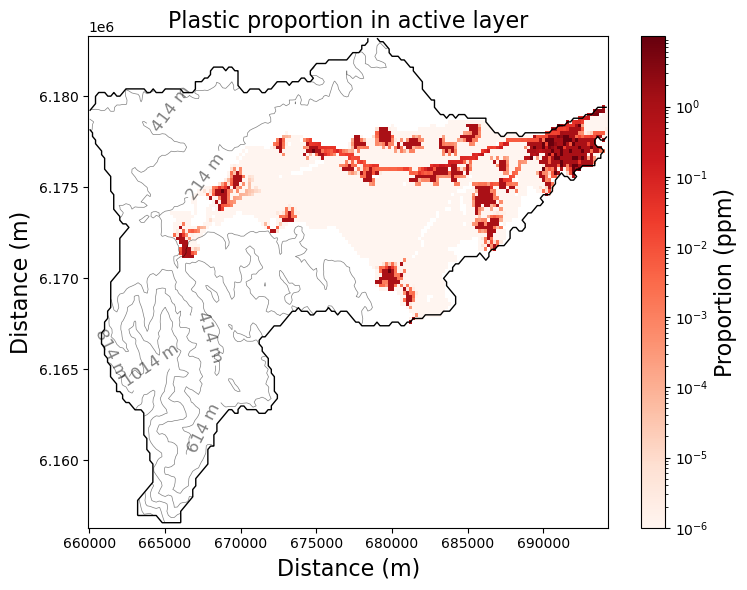

In [11]:
Z = np.divide(grain[:, :, 0], active) * 1e6
plt.figure(figsize=[6 * ncols / nrows, 6])
plt.pcolormesh(x, y, Z, norm=colors.LogNorm(vmin=1e-6, vmax=np.nanmax(Z.flatten())), cmap='Reds')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Proportion (ppm)', fontsize=16)
#plt.pcolormesh(x, y, water, norm=colors.LogNorm(vmin=1e-2, vmax=water.max()), cmap='Blues', alpha=0.3)
cs = plt.contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=12)

dem = z.copy()
dem[np.isnan(dem)] = -9999
plt.contour(x, y, dem, levels=0, linewidths=1, colors=[(0,0,0)])

plt.xlabel('Distance (m)', fontsize=16)
plt.ylabel('Distance (m)', fontsize=16)
plt.title('Plastic proportion in active layer', fontsize=16)
plt.tight_layout()
plt.savefig(f'plots/tet-plastic-{fname}-{res}-r40-v{vdrop}-t{int(np.floor(time))}.png', dpi=300)
plt.show()

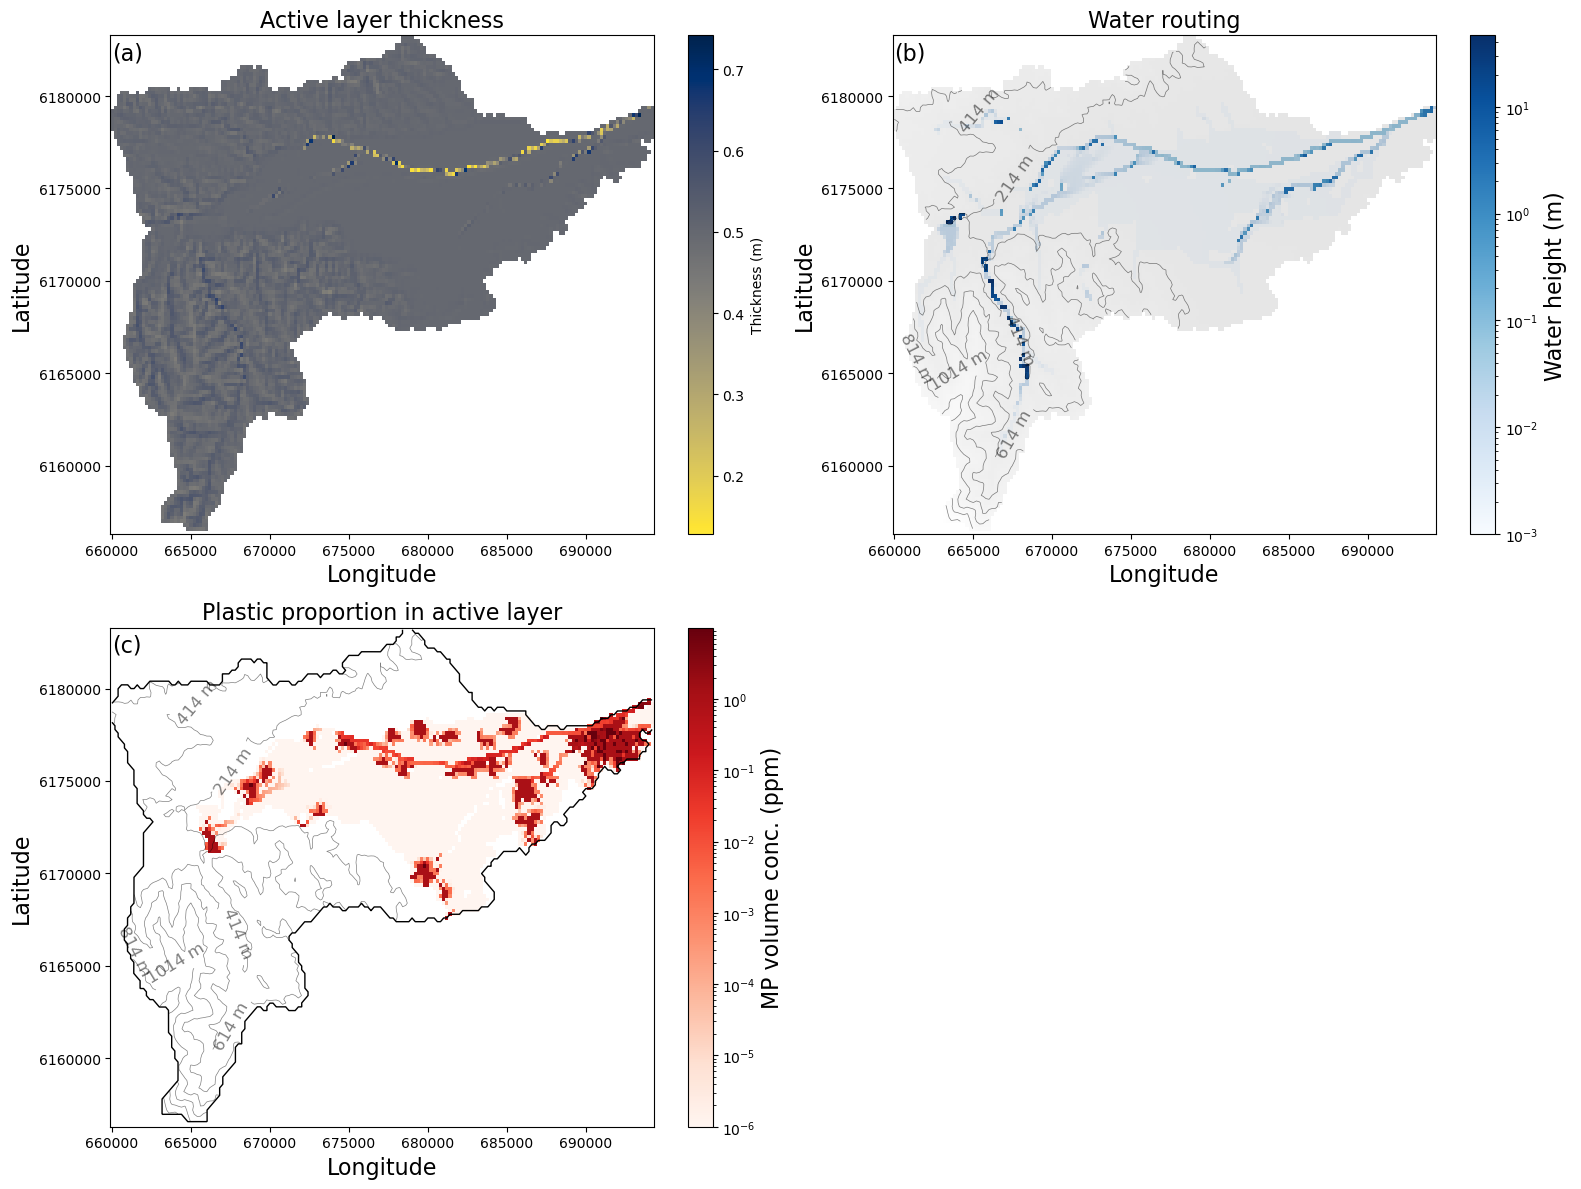

In [12]:
fig, axs = plt.subplots(2, 2, figsize=[16, 12])

pc = axs[0, 0].pcolormesh(x, y, active, cmap='cividis_r')
plt.colorbar(pc, label='Thickness (m)', ax=axs[0, 0])
axs[0, 0].ticklabel_format(style='plain')
axs[0, 0].set_xlabel('Longitude', fontsize=16)
axs[0, 0].set_ylabel('Latitude', fontsize=16)
axs[0, 0].set_title('Active layer thickness', fontsize=16)
axs[0, 0].text(660000, 6182000, '(a)', fontsize=16)

pc = axs[0, 1].pcolormesh(x, y, water, norm=colors.LogNorm(vmin=1e-3, vmax=water.max()), cmap='Blues')
cbar = plt.colorbar(pc, ax=axs[0, 1])
cbar.ax.set_ylabel('Water height (m)', fontsize=16)
axs[0, 1].pcolormesh(x, y, z, cmap='gray', alpha=0.1)
cs = axs[0, 1].contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=12)
axs[0, 1].ticklabel_format(style='plain')
axs[0, 1].set_xlabel('Longitude', fontsize=16)
axs[0, 1].set_ylabel('Latitude', fontsize=16)
axs[0, 1].set_title('Water routing', fontsize=16)
axs[0, 1].text(660000, 6182000, '(b)', fontsize=16)

pc = axs[1, 0].pcolormesh(x, y, Z, norm=colors.LogNorm(vmin=1e-6, vmax=np.nanmax(Z.flatten())), cmap='Reds')
cbar = plt.colorbar(pc, ax=axs[1, 0])
cbar.ax.set_ylabel('MP volume conc. (ppm)', fontsize=16)
cs = axs[1, 0].contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
axs[1, 0].clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=12)
axs[1, 0].contour(x, y, dem, levels=0, linewidths=1, colors=[(0,0,0)])
axs[1, 0].ticklabel_format(style='plain')
axs[1, 0].set_xlabel('Longitude', fontsize=16)
axs[1, 0].set_ylabel('Latitude', fontsize=16)
axs[1, 0].set_title('Plastic proportion in active layer', fontsize=16)
axs[1, 0].text(660000, 6182000, '(c)', fontsize=16)

axs[1, 1].axis('off')

plt.tight_layout()
plt.savefig(f'plots/tet-{fname}-{res}-r40-v{vdrop}-t{int(np.floor(time))}.png', dpi=300)
plt.show()


In [ ]:
filename = path_to_file/'input_data/plastic-source-pop-200m-mid.asc'

In [ ]:
gmax = 10
imax = nrows
jmax = ncols
smax = 10
index = np.zeros((imax, jmax))
grain = np.zeros((imax, jmax, gmax))
strata = np.ones((imax, jmax, smax, gmax))

active_layer = 1  # active layer thickness

dprops = np.array([0, 0.3244, 0.2335, 0.2206, 0.1375, 0.0508, 0.0187, 0.0047, 0])

for i in range(imax):
    for j in range(jmax):
        for gid, dprop in enumerate(dprops):
            if z[i, j] > 0:
                grain[i, j, gid] = dprop * active_layer
            else:
                grain[i, j, gid] = np.nan

with open(filename) as file:

    #Index coordinates
    x1 = 0
    y1 = 0

    for line in file:
        
        line_vector = line.rstrip().split()

        x1 = int(line_vector[0]) - 1
        y1 = int(line_vector[1]) - 1

        for n in range(gmax):
            grain[x1, y1, n] = float(line_vector[4 + n])

In [ ]:
active = np.zeros((imax, jmax))
for i in range(imax):
    for j in range(jmax):
        active[i, j] = np.sum(grain[i, j, :])

In [ ]:
Z0 = np.divide(grain[:, :, 0], active) * 100
Plastic_diff = Z - Z0
pmax = np.max(np.abs(Plastic_diff))

In [ ]:
plt.figure(figsize=[6 * ncols / nrows, 6])
plt.pcolormesh(x, y, Z0, norm=colors.LogNorm(vmin=1e-4, vmax=np.nanmax(Z.flatten())), cmap='Reds')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Proportion (%)', fontsize=16)
#plt.pcolormesh(x, y, water, norm=colors.LogNorm(vmin=1e-2, vmax=water.max()), cmap='Blues', alpha=0.3)
cs = plt.contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=12)
plt.xlabel('Distance (m)', fontsize=16)
plt.ylabel('Distance (m)', fontsize=16)
plt.title('Plastic proportion in active layer', fontsize=16)
plt.tight_layout()
#plt.savefig(f'plots/tet-plastic-{res}-r40-v{vdrop}-t{int(np.floor(time))}.png', dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=[6 * ncols / nrows, 6])
#cm = plt.pcolormesh(X, Y, water, norm=colors.LogNorm(vmin=1e-3, vmax=water.max()), cmap='gray_r', alpha=0.5)
#cbar = plt.colorbar(cm, location='left')
cbar.ax.set_ylabel('Water flux', fontsize=16)
cm = plt.pcolormesh(x, y, Plastic_diff, cmap='RdBu_r', vmax=pmax, vmin=-pmax)
cbar = plt.colorbar(cm)
cbar.ax.set_ylabel('$\Delta P$', fontsize=16)
cs = plt.contour(x, y, z, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=12)
plt.xlabel('Distance (m)', fontsize=16)
plt.ylabel('Distance (m)', fontsize=16)
plt.title('Change in plastic concentration', fontsize=16)
plt.tight_layout()
#plt.savefig('plots/tet-plastic-diff.png', dpi=300)
plt.show()


### Plot time series 

In [ ]:
file = path_to_file/f'{fname}{res}_r40_v{vdrop}/results/sedoutput.dat'
seds_MPMWplastic = pd.read_csv(file, sep=' ', index_col=False,
                    names=['Time Step',
                           'Qw(actual)', 
                           'Qw(expected)', 
                           'Blank',
                           'Qs',
                           'plastic',
                           'silt', 
                           'very fine sand', 
                           'fine sand',
                           'medium sand',
                           'coarse sand',
                           'granulite',
                           'pebble',
                           'zeros'])

density = 1330
rock = 2660
seds_MPMWplastic['SSC'] = seds_MPMWplastic['silt'] * rock / (seds_MPMWplastic['Qw(actual)'] * 60 * 60 * 24) * 1000 # daily time step for seds
seds_MPMWplastic['SPC'] = seds_MPMWplastic['plastic'] * density / (seds_MPMWplastic['Qw(actual)'] * 60 * 60 * 24) * 1000 # daily time step for seds

In [ ]:
cols_plot = ['Qw(actual)',
             'plastic',
             'silt']
cols_label = ['Qw (m³/hr)',
             'Plastic (m³/day)',
             'Silt (m³/day)']

fg, axs = plt.subplots(3, 1, figsize=[12, 6])
axs[0].plot(seds_MPMWplastic['Time Step'], seds_MPMWplastic[cols_plot[0]], 'k')
axs[0].set_ylabel(cols_label[0])
#axs[0].set_xlim(0, 650)

axs[1].plot(seds_MPMWplastic['Time Step'], seds_MPMWplastic[cols_plot[1]], 'k')
axs[1].set_ylabel(cols_label[1])
#axs[1].set_xlim(0, 650)

axs[2].plot(seds_MPMWplastic['Time Step'], seds_MPMWplastic[cols_plot[2]], 'k')
axs[2].set_ylabel(cols_label[2])
#axs[2].set_xlim(0, 650)

plt.xlabel('Day')
plt.tight_layout()
plt.savefig(f'plots/tet-tseries-{res}-r40-v{vdrop}.png', dpi=300)
plt.show()